This notebook allows to download the data from MP for some phase field, make disorder predictions for compounds in this phase field, and plot it using modified version of pymatgen PDPlotter

## Plotting phase diagram

In [1]:
import numpy as np
import pandas as pd
import json
import re
import os
import ast
import matplotlib.pyplot as plt

from pymatgen.ext.matproj import MPRester
import json
import matplotlib.pyplot as plt
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
%matplotlib inline

In [2]:
path='/Users/elenapatyukova/Documents/Disorder-prediction/Disorder-prediction-new-paper/'

### Modified plotter from pymatgen (disorder labels are added to the floating labels)

In [3]:
from __future__ import annotations

import collections
import itertools
import json
import logging
import math
import os
import re
import warnings
from functools import lru_cache
from typing import TYPE_CHECKING, Any, Literal, no_type_check

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.font_manager import FontProperties
from monty.json import MontyDecoder, MSONable
from scipy import interpolate
from scipy.optimize import minimize
from scipy.spatial import ConvexHull
from tqdm import tqdm

from pymatgen.analysis.reaction_calculator import Reaction, ReactionError
from pymatgen.core import DummySpecies, Element
from pymatgen.core.composition import Composition
from pymatgen.entries import Entry
from pymatgen.util.coord import Simplex, in_coord_list
from pymatgen.util.due import Doi, due
from pymatgen.util.plotting import pretty_plot
from pymatgen.util.string import htmlify, latexify

if TYPE_CHECKING:
    from collections.abc import Collection, Iterator, Sequence
    from io import StringIO

    from numpy.typing import ArrayLike


import matplotlib.pyplot as plt
import plotly.graph_objects as go

with open(path+'plotly_pd_layouts.json') as file:
    plotly_layouts = json.load(file)

class PDPlotter_dis(PDPlotter):
    """
    Modification of PDPlotter to show compositions which are predicted to be disordered
    
    """
    def __init__(
        self,
        show_disorder: bool = True,
        **kwargs
        ):

        self.show_disorder = show_disorder
        super().__init__(**kwargs)
    
    def _create_plotly_markers(self, highlight_entries=None, label_uncertainties=False):
        """
        Creates stable and unstable marker plots for overlaying on the phase diagram.

        Returns:
            Tuple of Plotly go.Scatter (unary, binary), go.Scatterternary(ternary_2d),
            or go.Scatter3d (ternary_3d, quaternary) objects in order:
            (stable markers, unstable markers)
        """
        def get_marker_props(coords, entries):
            """Method for getting marker locations, hovertext, and error bars
            from pd_plot_data.
            """
            x, y, z, texts, energies, uncertainties = [], [], [], [], [], []

            is_stable = [entry in self._pd.stable_entries for entry in entries]

            for coord, entry, stable in zip(coords, entries, is_stable):
                energy = round(self._pd.get_form_energy_per_atom(entry), 3)
                if(self.show_disorder):
                    disorder = entry.data['disorder']
                    entropy = round(entry.data['configurational_entropy'],3)

                entry_id = getattr(entry, "entry_id", "no ID")
                comp = entry.composition

                if hasattr(entry, "original_entry"):
                    orig_entry = entry.original_entry
                    comp = orig_entry.composition
                    entry_id = getattr(orig_entry, "entry_id", "no ID")

                formula = comp.reduced_formula
                clean_formula = htmlify(formula)
                if(self.show_disorder):
                    label = f"{clean_formula} ({entry_id}) <br> disorder = {disorder} <br> entropy = {entropy} k_B/atom ({round(entropy*0.026,5)} eV/atom at 300K)  <br> {energy} eV/atom"
                else:
                    label = f"{clean_formula} ({entry_id}) <br> {energy} eV/atom"

                if not stable:
                    e_above_hull = round(self._pd.get_e_above_hull(entry), 3)
                    if e_above_hull > self.show_unstable:
                        continue
                    label += f" ({e_above_hull:+} eV/atom)"
                    energies.append(e_above_hull)
                else:
                    uncertainty = 0
                    label += " (Stable)"
                    if hasattr(entry, "correction_uncertainty_per_atom") and label_uncertainties:
                        uncertainty = round(entry.correction_uncertainty_per_atom, 4)
                        label += f"<br> (Error: +/- {uncertainty} eV/atom)"

                    uncertainties.append(uncertainty)
                    energies.append(energy)

                texts.append(label)

                if self._dim == 3 and self.ternary_style == "2d":
                    for el, axis in zip(self._pd.elements, [x, y, z]):
                        axis.append(entry.composition[el])
                else:
                    x.append(coord[0])
                    y.append(coord[1])

                    if self._dim == 3:
                        z.append(energy)
                    elif self._dim == 4:
                        z.append(coord[2])

            return {"x": x, "y": y, "z": z, "texts": texts, "energies": energies, "uncertainties": uncertainties}

        if highlight_entries is None:
            highlight_entries = []

        stable_coords, stable_entries = [], []
        unstable_coords, unstable_entries = [], []
        highlight_coords, highlight_ents = [], []

        for coord, entry in zip(self.pd_plot_data[1], self.pd_plot_data[1].values()):
            if entry in highlight_entries:
                highlight_coords.append(coord)
                highlight_ents.append(entry)
            else:
                stable_coords.append(coord)
                stable_entries.append(entry)

        for coord, entry in zip(self.pd_plot_data[2].values(), self.pd_plot_data[2]):
            if entry in highlight_entries:
                highlight_coords.append(coord)
                highlight_ents.append(entry)
            else:
                unstable_coords.append(coord)
                unstable_entries.append(entry)

        stable_props = get_marker_props(stable_coords, stable_entries)
        unstable_props = get_marker_props(unstable_coords, unstable_entries)
        highlight_props = get_marker_props(highlight_coords, highlight_entries)

        stable_markers, unstable_markers, highlight_markers = {}, {}, {}

        if self._dim == 1:
            stable_markers = plotly_layouts["default_unary_marker_settings"].copy()
            unstable_markers = plotly_layouts["default_unary_marker_settings"].copy()

            stable_markers.update(
                x=[0] * len(stable_props["y"]),
                y=list(stable_props["x"]),
                name="Stable",
                marker={
                    "color": "darkgreen",
                    "size": 20,
                    "line": {"color": "black", "width": 2},
                    "symbol": "star",
                },
                opacity=0.9,
                hovertext=stable_props["texts"],
                error_y={
                    "array": list(stable_props["uncertainties"]),
                    "type": "data",
                    "color": "gray",
                    "thickness": 2.5,
                    "width": 5,
                },
            )
            plotly_layouts["unstable_colorscale"].copy()
            unstable_markers.update(
                x=[0] * len(unstable_props["y"]),
                y=list(unstable_props["x"]),
                name="Above Hull",
                marker={
                    "color": unstable_props["energies"],
                    "colorscale": plotly_layouts["unstable_colorscale"],
                    "size": 16,
                    "symbol": "diamond-wide",
                    "line": {"color": "black", "width": 2},
                },
                hovertext=unstable_props["texts"],
                opacity=0.9,
            )

            if highlight_entries:
                highlight_markers = plotly_layouts["default_unary_marker_settings"].copy()
                highlight_markers.update(
                    {
                        "x": [0] * len(highlight_props["y"]),
                        "y": list(highlight_props["x"]),
                        "name": "Highlighted",
                        "marker": {
                            "color": "mediumvioletred",
                            "size": 22,
                            "line": {"color": "black", "width": 2},
                            "symbol": "square",
                        },
                        "opacity": 0.9,
                        "hovertext": highlight_props["texts"],
                        "error_y": {
                            "array": list(highlight_props["uncertainties"]),
                            "type": "data",
                            "color": "gray",
                            "thickness": 2.5,
                            "width": 5,
                        },
                    }
                )

        if self._dim == 2:
            stable_markers = plotly_layouts["default_binary_marker_settings"].copy()
            unstable_markers = plotly_layouts["default_binary_marker_settings"].copy()

            stable_markers.update(
                x=list(stable_props["x"]),
                y=list(stable_props["y"]),
                name="Stable",
                marker={"color": "darkgreen", "size": 16, "line": {"color": "black", "width": 2}},
                opacity=0.99,
                hovertext=stable_props["texts"],
                error_y={
                    "array": list(stable_props["uncertainties"]),
                    "type": "data",
                    "color": "gray",
                    "thickness": 2.5,
                    "width": 5,
                },
            )
            unstable_markers.update(
                {
                    "x": list(unstable_props["x"]),
                    "y": list(unstable_props["y"]),
                    "name": "Above Hull",
                    "marker": {
                        "color": unstable_props["energies"],
                        "colorscale": plotly_layouts["unstable_colorscale"],
                        "size": 7,
                        "symbol": "diamond",
                        "line": {"color": "black", "width": 1},
                        "opacity": 0.8,
                    },
                    "hovertext": unstable_props["texts"],
                }
            )
            if highlight_entries:
                highlight_markers = plotly_layouts["default_binary_marker_settings"].copy()
                highlight_markers.update(
                    x=list(highlight_props["x"]),
                    y=list(highlight_props["y"]),
                    name="Highlighted",
                    marker={
                        "color": "mediumvioletred",
                        "size": 16,
                        "line": {"color": "black", "width": 2},
                        "symbol": "square",
                    },
                    opacity=0.99,
                    hovertext=highlight_props["texts"],
                    error_y={
                        "array": list(highlight_props["uncertainties"]),
                        "type": "data",
                        "color": "gray",
                        "thickness": 2.5,
                        "width": 5,
                    },
                )

        elif self._dim == 3 and self.ternary_style == "2d":
            stable_markers = plotly_layouts["default_ternary_2d_marker_settings"].copy()
            unstable_markers = plotly_layouts["default_ternary_2d_marker_settings"].copy()

            stable_markers.update(
                {
                    "a": list(stable_props["x"]),
                    "b": list(stable_props["y"]),
                    "c": list(stable_props["z"]),
                    "name": "Stable",
                    "hovertext": stable_props["texts"],
                    "marker": {
                        "color": "green",
                        "line": {"width": 2.0, "color": "black"},
                        "symbol": "circle",
                        "size": 15,
                    },
                }
            )
            unstable_markers.update(
                {
                    "a": unstable_props["x"],
                    "b": unstable_props["y"],
                    "c": unstable_props["z"],
                    "name": "Above Hull",
                    "hovertext": unstable_props["texts"],
                    "marker": {
                        "color": unstable_props["energies"],
                        "opacity": 0.8,
                        "colorscale": plotly_layouts["unstable_colorscale"],
                        "line": {"width": 1, "color": "black"},
                        "size": 7,
                        "symbol": "diamond",
                        "colorbar": {
                            "title": "Energy Above Hull<br>(eV/atom)",
                            "x": 0,
                            "y": 1,
                            "yanchor": "top",
                            "xpad": 0,
                            "ypad": 0,
                            "thickness": 0.02,
                            "thicknessmode": "fraction",
                            "len": 0.5,
                        },
                    },
                }
            )
            if highlight_entries:
                highlight_markers = plotly_layouts["default_ternary_2d_marker_settings"].copy()
                highlight_markers.update(
                    {
                        "a": list(highlight_props["x"]),
                        "b": list(highlight_props["y"]),
                        "c": list(highlight_props["z"]),
                        "name": "Highlighted",
                        "hovertext": highlight_props["texts"],
                        "marker": {
                            "color": "mediumvioletred",
                            "line": {"width": 2.0, "color": "black"},
                            "symbol": "square",
                            "size": 16,
                        },
                    }
                )

        elif self._dim == 3 and self.ternary_style == "3d":
            stable_markers = plotly_layouts["default_ternary_3d_marker_settings"].copy()
            unstable_markers = plotly_layouts["default_ternary_3d_marker_settings"].copy()

            stable_markers.update(
                {
                    "x": list(stable_props["y"]),
                    "y": list(stable_props["x"]),
                    "z": list(stable_props["z"]),
                    "name": "Stable",
                    "marker": {
                        "color": "#1e1e1f",
                        "size": 11,
                        "opacity": 0.99,
                    },
                    "hovertext": stable_props["texts"],
                    "error_z": {
                        "array": list(stable_props["uncertainties"]),
                        "type": "data",
                        "color": "darkgray",
                        "width": 10,
                        "thickness": 5,
                    },
                }
            )
            unstable_markers.update(
                {
                    "x": unstable_props["y"],
                    "y": unstable_props["x"],
                    "z": unstable_props["z"],
                    "name": "Above Hull",
                    "hovertext": unstable_props["texts"],
                    "marker": {
                        "color": unstable_props["energies"],
                        "colorscale": plotly_layouts["unstable_colorscale"],
                        "size": 5,
                        "line": {"color": "black", "width": 1},
                        "symbol": "diamond",
                        "opacity": 0.7,
                        "colorbar": {
                            "title": "Energy Above Hull<br>(eV/atom)",
                            "x": 0,
                            "y": 1,
                            "yanchor": "top",
                            "xpad": 0,
                            "ypad": 0,
                            "thickness": 0.02,
                            "thicknessmode": "fraction",
                            "len": 0.5,
                        },
                    },
                }
            )
            if highlight_entries:
                highlight_markers = plotly_layouts["default_ternary_3d_marker_settings"].copy()
                highlight_markers.update(
                    {
                        "x": list(highlight_props["y"]),
                        "y": list(highlight_props["x"]),
                        "z": list(highlight_props["z"]),
                        "name": "Highlighted",
                        "marker": {
                            "size": 12,
                            "opacity": 0.99,
                            "symbol": "square",
                            "color": "mediumvioletred",
                        },
                        "hovertext": highlight_props["texts"],
                        "error_z": {
                            "array": list(highlight_props["uncertainties"]),
                            "type": "data",
                            "color": "darkgray",
                            "width": 10,
                            "thickness": 5,
                        },
                    }
                )

        elif self._dim == 4:
            stable_markers = plotly_layouts["default_quaternary_marker_settings"].copy()
            unstable_markers = plotly_layouts["default_quaternary_marker_settings"].copy()
            stable_markers.update(
                {
                    "x": stable_props["x"],
                    "y": stable_props["y"],
                    "z": stable_props["z"],
                    "name": "Stable",
                    "marker": {
                        "size": 7,
                        "opacity": 0.99,
                        "color": "darkgreen",
                        "line": {"color": "black", "width": 1},
                    },
                    "hovertext": stable_props["texts"],
                }
            )
            unstable_markers.update(
                {
                    "x": unstable_props["x"],
                    "y": unstable_props["y"],
                    "z": unstable_props["z"],
                    "name": "Above Hull",
                    "marker": {
                        "color": unstable_props["energies"],
                        "colorscale": plotly_layouts["unstable_colorscale"],
                        "size": 5,
                        "symbol": "diamond",
                        "line": {"color": "black", "width": 1},
                        "colorbar": {
                            "title": "Energy Above Hull<br>(eV/atom)",
                            "x": 0,
                            "y": 1,
                            "yanchor": "top",
                            "xpad": 0,
                            "ypad": 0,
                            "thickness": 0.02,
                            "thicknessmode": "fraction",
                            "len": 0.5,
                        },
                    },
                    "hovertext": unstable_props["texts"],
                    "visible": "legendonly",
                }
            )
            if highlight_entries:
                highlight_markers = plotly_layouts["default_quaternary_marker_settings"].copy()
                highlight_markers.update(
                    {
                        "x": highlight_props["x"],
                        "y": highlight_props["y"],
                        "z": highlight_props["z"],
                        "name": "Highlighted",
                        "marker": {
                            "size": 9,
                            "opacity": 0.99,
                            "symbol": "square",
                            "color": "mediumvioletred",
                            "line": {"color": "black", "width": 1},
                        },
                        "hovertext": highlight_props["texts"],
                    }
                )

        highlight_marker_plot = None

        if self._dim in [1, 2]:
            stable_marker_plot, unstable_marker_plot = (
                go.Scatter(**markers) for markers in [stable_markers, unstable_markers]
            )

            if highlight_entries:
                highlight_marker_plot = go.Scatter(**highlight_markers)
        elif self._dim == 3 and self.ternary_style == "2d":
            stable_marker_plot, unstable_marker_plot = (
                go.Scatterternary(**markers) for markers in [stable_markers, unstable_markers]
            )
            if highlight_entries:
                highlight_marker_plot = go.Scatterternary(**highlight_markers)
        else:
            stable_marker_plot, unstable_marker_plot = (
                go.Scatter3d(**markers) for markers in [stable_markers, unstable_markers]
            )
            if highlight_entries:
                highlight_marker_plot = go.Scatter3d(**highlight_markers)

        return stable_marker_plot, unstable_marker_plot, highlight_marker_plot

### Loading phase field data from MP

In [127]:
API_KEY = "tfmgnRMn6JItPN8S8W9y7yzvm3R8o2Z4"

a = MPRester(API_KEY)

#Entries are the basic unit for thermodynamic and other analyses in pymatgen.
#This gets all entries belonging to the Ca-C-O system.
entries = a.get_entries_in_chemsys(['Mg', 'Al', 'Fe'])

/Users/elenapatyukova/anaconda3/envs/py3/lib/python3.11/site-packages/mp_api/client/mprester.py:182: UserWarning:

mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'



Retrieving ThermoDoc documents:   0%|          | 0/86 [00:00<?, ?it/s]

In [128]:
compositions=[]
for entry in entries:
    compositions.append(entry.composition.formula)

In [129]:
data=pd.DataFrame()
data['formula']=compositions
data['target']=np.zeros(len(compositions),dtype=int)
data.to_csv('phase_field.csv')

In [130]:
import os
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import roc_auc_score

from crabnet.kingcrab import CrabNet
from crabnet.model import Model
from utils.get_compute_device import get_compute_device

In [131]:
compute_device = get_compute_device(prefer_last=True)
RNG_SEED = 42
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

In [152]:
path=path='/Users/elenapatyukova/Documents/Disorder-prediction/Disorder-prediction-new-paper/Disorder_for_MP/'
# data_file = path+'phase_field.csv'
data_file = path+'test 1.csv'

In [153]:
result=pd.read_csv(data_file)

In [154]:
result

,Unnamed: 0,formula,target
0,0,Al2.475 Au5.25 Cu4.275,1
1,1,C3 As4 F24 N3 Te6,0
2,2,Ag0.87 Ge4 Na7.13 Se10,1
3,3,Ba7.998 Ca2.666 O23.994 W2.666 Zr2.666,1
4,4,Nb6 Sn4.92,1
...,...,...,...
9841,9841,Ag0.95 Sb0.05,1
9842,9842,O18 Rb2 Ta6 Ti1,1
9843,9843,H9 B9 Rb2,1
9844,9844,Al1 B14 Ho1,0


In [155]:
mat_prop='disorder'
verbose=True

model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                  model_name=f'{mat_prop}', verbose=verbose)
model.classification = True


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



In [156]:
result=pd.DataFrame()
result['formula']=compositions

In [157]:
n_disorder_models=5

for i in range(n_disorder_models):
    model.load_network(f'{mat_prop}'+str(i)+'.pth')
    # data is reloaded to model.data_loader
    model.load_data(data_file, batch_size=2**9, train=False)
    output = model.predict(model.data_loader)
    means=[]
    stds=[]
    for comp in result['formula'].values:
        if comp in output[2]:
            ind=list(output[2]).index(comp)
            means.append(output[1][ind])
            stds.append(output[3][ind])
        else:
            means.append(0)
            stds.append(0)
    result['mean'+str(i)]=means
    result['std'+str(i)]=stds
means=np.zeros(len(result))
stds=np.zeros(len(result))
for i in range(n_disorder_models):
    means+=result['mean'+str(i)]
means=means/n_disorder_models
dis=[m>0.5 for m in means]
for i in range(n_disorder_models):
    stds+=(result['mean'+str(i)]-means)**2+result['std'+str(i)]**2
stds=(stds/n_disorder_models)**0.5

result['disorder']=dis
result['mean_dis_prob']=means
result['std_dis_prob']=stds

Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 223262.56formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 266412.92formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 256974.85formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 257459.12formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 264478.04formulae/s]


loading data with up to 13 elements in the formula


In [158]:
mat_prop='entropy'
verbose=True

model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                  model_name=f'{mat_prop}', verbose=verbose)
model.classification = False


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



In [159]:
n_entropy_models=5

for i in range(0,n_entropy_models):
    model.load_network(f'{mat_prop}'+str(i)+'.pth')
    # data is reloaded to model.data_loader
    model.load_data(data_file, batch_size=2**9, train=False)
    output = model.predict(model.data_loader)
    means=[]
    stds=[]
    for comp in result['formula'].values:
        if comp in output[2] and result.loc[result['formula']==comp]['disorder'].values[0]==True:
            ind=list(output[2]).index(comp)
            means.append(output[1][ind])
            stds.append(output[3][ind])
        else:
            means.append(0)
            stds.append(0)
    result['ent_mean'+str(i)]=means
    result['ent_std'+str(i)]=stds
means=np.zeros(len(result))
stds=np.zeros(len(result))
for i in range(n_entropy_models):
    means+=result['ent_mean'+str(i)]
means=means/n_entropy_models
for i in range(n_entropy_models):
    stds+=(result['ent_mean'+str(i)]-means)**2+result['std'+str(i)]**2
stds=(stds/n_entropy_models)**0.5

result['entropy']=means
result['std_entropy']=stds

Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 263310.05formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 265006.35formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 259256.45formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 264388.22formulae/s]


loading data with up to 13 elements in the formula


Generating EDM: 100%|██████████| 9837/9837 [00:00<00:00, 265125.55formulae/s]


loading data with up to 13 elements in the formula


In [140]:
# table=result[['formula','disorder','mean_dis_prob','std_dis_prob','entropy','std_entropy']]

In [160]:
table=result[['formula','target','disorder','mean_dis_prob','std_dis_prob']]
table.head(30)

,formula,target,disorder,mean_dis_prob,std_dis_prob
0,Al2.475 Au5.25 Cu4.275,1,True,0.999300,0.279136
1,C3 As4 F24 N3 Te6,0,False,0.288203,2.306659
2,Ag0.87 Ge4 Na7.13 Se10,1,True,0.793963,3.540279
3,Ba7.998 Ca2.666 O23.994 W2.666 Zr2.666,1,True,0.993583,0.337009
4,Nb6 Sn4.92,1,True,0.966870,0.355740
5,Ge0.7 Sb0.2 Se0.5 Te0.5,1,True,0.999457,0.415968
6,Ba5 Cl1 Fe3.488 O13 Pt1.512,1,True,0.996665,0.387268
7,Cu3 O12 Ti4 Tm0.667,1,True,0.999997,0.219470
8,Al1 Mn0.5 O12 P3 Sb1,1,True,0.996310,0.463056
9,Ba2 Ca0.2 Cu2 Hg1.4 O8 Tl0.6 Y0.8,1,True,0.999997,0.327420


In [142]:
# from sklearn.metrics import accuracy_score,confusion_matrix, precision_score,recall_score

# accuracy_score(table['target'],table['disorder'])

In [143]:
# precision_score(table['target'],table['disorder'])

In [144]:
# recall_score(table['target'],table['disorder'])

In [145]:
# tn, fp, fn, tp = confusion_matrix(table['target'],table['disorder']).ravel()
# tn, fp, fn, tp

In [146]:
for entry in entries:
    dx=result.loc[result['formula']==entry.composition.formula]
    entry.data['disorder']=dx['disorder'].values[0]
    entry.data['configurational_entropy']=round(dx['entropy'].values[0],3)

In [147]:
phased = PhaseDiagram(entries)

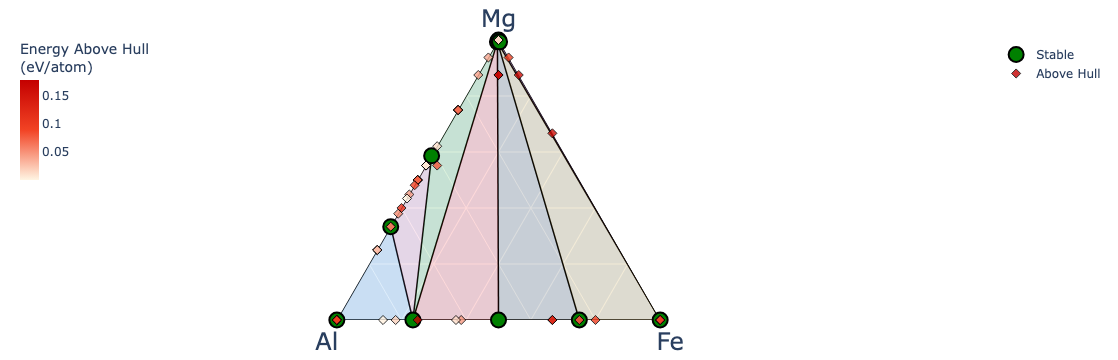

In [148]:
plotter = PDPlotter_dis(phasediagram=phased, show_unstable=0.2, show_disorder=True, backend='plotly')

plotter.show()

In [161]:
18/29

0.6206896551724138

In [149]:
table.loc[table['disorder']==True].head(50)

,formula,disorder,mean_dis_prob,std_dis_prob,entropy,std_entropy
8,Mg16 Al12 Fe1,True,0.999605,0.630321,0.136529,0.630686
9,Mg12 Al2 Fe2,True,0.997526,0.326287,0.170882,0.326301
10,Mg12 Al2 Fe2,True,0.997526,0.326287,0.170882,0.326301
11,Mg14 Al1 Fe1,True,0.832011,0.559570,0.189038,0.531700
12,Mg14 Al1 Fe1,True,0.832011,0.559570,0.189038,0.531700
13,Mg15 Fe1,True,0.999889,0.316365,0.228969,0.316419
14,Mg3 Fe1,True,0.902066,0.311691,0.287961,0.344607
15,Mg6 Fe2,True,0.902066,0.311691,0.287961,0.344607
16,Mg7 Fe1,True,0.760233,0.611981,0.119890,0.513762
18,Mg149 Fe1,True,1.000000,0.223660,0.037200,0.223668


In [150]:
len(table.loc[table['disorder']==True])/len(table)

0.32558139534883723

In [151]:
len(entries)

86